<a href="https://colab.research.google.com/github/Jrk373/MachineLearningDemo/blob/main/DecisionTreeClasifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regeression Tree from start to finish

## Introduction

## Stage 1: Business UNderstanding

## Stage 2: Data Understanding

### Data Set

In [1]:
import pandas as pd  # to load and manipulate data and for One-Hot Encoding
import numpy as np  # to calculate the mean and standard deviation
import matplotlib.pyplot as plt  # to draw graphs
from sklearn.tree import DecisionTreeClassifier  # to build a classification tree
from sklearn.tree import plot_tree  # to draw a classification tree
from sklearn.model_selection import train_test_split  # to split data into training and testing sets
from sklearn.model_selection import cross_val_score  # for cross validation
from sklearn.metrics import ConfusionMatrixDisplay  # creates and draws a confusion matrix


In [2]:
import urllib.request

# Corrected URL with raw content
url = 'https://raw.githubusercontent.com/Jrk373/MachineLearningDemo/main/watson_healthcare_modified.csv'
file_path = 'watson_healthcare_modified.csv'

# Download the file
urllib.request.urlretrieve(url, file_path)

# Load the dataset
try:
    df = pd.read_csv(file_path)
    print('Successfully downloaded', file_path)
    print('Data successfully loaded as data frame "df"')
except pd.errors.ParserError as e:
    print("ParserError encountered:", e)
    print("Attempting to load with alternative options...")
    df = pd.read_csv(file_path, delimiter=',', error_bad_lines=False)
    print("Data loaded with error handling.")


Successfully downloaded watson_healthcare_modified.csv
Data successfully loaded as data frame "df"


### Data Shape

Assessing the shape of data helps identify its dimensionality (rows and columns), which is crucial for understanding its structure and determining suitable analysis techniques. It ensures the dataset is in the expected format, enabling error detection and proper preprocessing. Additionally, knowing the data shape aids in resource optimization and selecting the right tools for analysis.

In [3]:
# Import necessary packages
import pandas as pd

# Check the shape (rows, columns)
print('Data set rows and columns:', df.shape)

Data set rows and columns: (1676, 35)


In [4]:
# Import necessary packages
import pandas as pd

# Print off the first 5 rows
print(df.head(5))

   EmployeeID  Age Attrition     BusinessTravel  DailyRate  Department  \
0     1313919   41        No      Travel_Rarely       1102  Cardiology   
1     1200302   49        No  Travel_Frequently        279   Maternity   
2     1060315   37       Yes      Travel_Rarely       1373   Maternity   
3     1272912   33        No  Travel_Frequently       1392   Maternity   
4     1414939   27        No      Travel_Rarely        591   Maternity   

   DistanceFromHome  Education EducationField  EmployeeCount  ...  \
0                 1          2  Life Sciences              1  ...   
1                 8          1  Life Sciences              1  ...   
2                 2          2          Other              1  ...   
3                 3          4  Life Sciences              1  ...   
4                 2          1        Medical              1  ...   

   RelationshipSatisfaction StandardHours  Shift  TotalWorkingYears  \
0                         1            80      0                  8  

In [5]:
# Import necessary packages
import pandas as pd

# Lets get more basic information on columns, datatypes etc using .info()
print('Feature Information:')
print(df.info())

Feature Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1676 entries, 0 to 1675
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   EmployeeID                1676 non-null   int64 
 1   Age                       1676 non-null   int64 
 2   Attrition                 1676 non-null   object
 3   BusinessTravel            1676 non-null   object
 4   DailyRate                 1676 non-null   int64 
 5   Department                1676 non-null   object
 6   DistanceFromHome          1676 non-null   int64 
 7   Education                 1676 non-null   int64 
 8   EducationField            1676 non-null   object
 9   EmployeeCount             1676 non-null   int64 
 10  EnvironmentSatisfaction   1676 non-null   int64 
 11  Gender                    1676 non-null   object
 12  HourlyRate                1676 non-null   int64 
 13  JobInvolvement            1676 non-null   int64 
 14  Job

## Stage 3: Data Preparation

### Drop unnecessary columns

In [6]:
# Columns to drop
columns_to_drop = ['EmployeeID',
                   'StandardHours',
                   'Over18',
                   'MonthlyRate',
                   'EmployeeCount']

# Drop those Columns like they're hot
df = df.drop(columns = columns_to_drop)

### NULL Values

In [7]:
# Deal with NA values
## Identify Variable with NaN values
def find_columns_with_nan(df):
    columns_with_nan = [col for col in df.columns if df[col].isna().any()]
    return columns_with_nan

### Identify Variable with NaN values
columns_with_nan = find_columns_with_nan(df)

if columns_with_nan:
    print("Columns with NaN values:", columns_with_nan)
else:
    print("There are no NaN values in the dataset.")

There are no NaN values in the dataset.


### Missing Values

In [8]:
# Identifying missing values in the dataset
missing_values = df.isnull().sum().sort_values(ascending=False)
missing_values = missing_values[missing_values > 0]  # Filter out columns with no missing values

if missing_values.empty:
    print("There are no missing values in the dataset.")
else:
    print("Missing values by column:")
    print(missing_values)

# Replacing missing values
    for column in df.columns:
        if df[column].isnull().any():  # Check if the column has missing values
            if df[column].dtype == 'object':  # For object (categorical) columns
                mode_value = df[column].mode()[0]
                df[column].fillna(mode_value, inplace=True)
                print(f"Missing values in column '{column}' replaced with mode: {mode_value}")
            elif df[column].dtype in ['float64', 'int64']:  # For numeric columns
                mean_value = df[column].mean()
                df[column].fillna(mean_value, inplace=True)
                print(f"Missing values in column '{column}' replaced with mean: {mean_value:.2f}")


There are no missing values in the dataset.


### Split X Feature Variables from Y Target Variable

In [9]:
# Split data to Target and Feature
Target = 'Attrition'

# Make a new copy of the columns used to make predictions
X = df.drop(Target, axis=1).copy()  # Alternatively: X = df_no_missing.iloc[:, :-1]

# Make a new copy of the column of data we want to predict
y = df[Target].copy()

# Check the shape of X and y
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

# If the number of samples is different, raise an error
if X.shape[0] != y.shape[0]:  # Use 'X' instead of 'x'
    raise ValueError("X and y must have the same number of samples.")


Shape of X: (1676, 29)
Shape of y: (1676,)


### Variable Encoding

#### Feature Variables

In [10]:
# Import necessary packages
import pandas as pd
import numpy as np

# Identify categorical columns - assuming they are of type 'object'
categorical_columns = X.select_dtypes(include=['object']).columns

## Print the shape to see how many new columns we have before updating
print(f"Shape before encoding: {X.shape}")

# Print unique values for each categorical column before encoding
print("Unique values in categorical columns before one-hot encoding:")
for column in categorical_columns:
    print(f"{column}: {df[column].unique()}")

Shape before encoding: (1676, 29)
Unique values in categorical columns before one-hot encoding:
BusinessTravel: ['Travel_Rarely' 'Travel_Frequently' 'Non-Travel']
Department: ['Cardiology' 'Maternity' 'Neurology']
EducationField: ['Life Sciences' 'Other' 'Medical' 'Marketing' 'Technical Degree'
 'Human Resources']
Gender: ['Female' 'Male']
JobRole: ['Nurse' 'Other' 'Therapist' 'Administrative' 'Admin']
MaritalStatus: ['Single' 'Married' 'Divorced']
OverTime: ['Yes' 'No']


##### One-hot Encoding

In [11]:
# Import necessary packages
import pandas as pd
import numpy as np

# Apply one-hot encoding to all categorical variables
df_encoded = pd.get_dummies(X)

In [12]:
# Import necessary packages
import pandas as pd
import numpy as np

## Print the shape to see how many new columns were added
print(f"Shape after encoding: {df_encoded.shape}")

# Identify new one-hot encoded columns
new_columns = [col for col in df_encoded.columns if col not in df.columns]

# Print unique values in the new one-hot encoded columns (they should only be 0 or 1)
print("\nUnique values in one-hot encoded columns:")
for column in new_columns:
    print(f"{column}: {df_encoded[column].unique()}")

Shape after encoding: (1676, 46)

Unique values in one-hot encoded columns:
BusinessTravel_Non-Travel: [False  True]
BusinessTravel_Travel_Frequently: [False  True]
BusinessTravel_Travel_Rarely: [ True False]
Department_Cardiology: [ True False]
Department_Maternity: [False  True]
Department_Neurology: [False  True]
EducationField_Human Resources: [False  True]
EducationField_Life Sciences: [ True False]
EducationField_Marketing: [False  True]
EducationField_Medical: [False  True]
EducationField_Other: [False  True]
EducationField_Technical Degree: [False  True]
Gender_Female: [ True False]
Gender_Male: [False  True]
JobRole_Admin: [False  True]
JobRole_Administrative: [False  True]
JobRole_Nurse: [ True False]
JobRole_Other: [False  True]
JobRole_Therapist: [False  True]
MaritalStatus_Divorced: [False  True]
MaritalStatus_Married: [False  True]
MaritalStatus_Single: [ True False]
OverTime_No: [False  True]
OverTime_Yes: [ True False]


In [13]:
# Count of each data type, including 0 counts
data_type_counts = {dtype: (df_encoded.dtypes == dtype).sum() for dtype in ["bool", "category", "datetime64[ns]", "float64", "int64", "object", "str"]}
data_type_counts = {k: v for k, v in sorted(data_type_counts.items())}  # Sort for clarity

# Print the data type counts
print("Data type counts (including 0 values):")
for dtype, count in data_type_counts.items():
    print(f"{dtype}: {count}")

Data type counts (including 0 values):
bool: 24
category: 0
datetime64[ns]: 0
float64: 0
int64: 22
object: 0
str: 0


In [14]:

# Check for boolean columns and convert them to integers
bool_columns = df_encoded.select_dtypes(include=["bool"]).columns
for col in bool_columns:
    df_encoded[col] = df_encoded[col].astype(int)

# Check for object columns in the DataFrame
object_columns = df_encoded.select_dtypes(include=["object"]).columns

# Convert object columns to integers using Label Encoding
for col in object_columns:
    df_encoded[col] = df_encoded[col].astype("category").cat.codes

# Count of each data type, including 0 counts
data_type_counts = {dtype: (df_encoded.dtypes == dtype).sum() for dtype in ["bool", "category", "datetime64[ns]", "float64", "int64", "object"]}
data_type_counts = {k: v for k, v in sorted(data_type_counts.items())}  # Sort for clarity

# Print the data type counts
print("Data type counts (including 0 values):")
for dtype, count in data_type_counts.items():
    print(f"{dtype}: {count}")


Data type counts (including 0 values):
bool: 0
category: 0
datetime64[ns]: 0
float64: 0
int64: 46
object: 0


In [15]:
X_encoded = df_encoded

for col in X_encoded.columns:
    print(f"{col}: {X_encoded[col].unique()}")

Age: [41 49 37 33 27 32 59 30 38 36 35 29 31 34 28 22 53 24 21 42 44 46 39 43
 50 26 48 55 45 56 23 51 40 54 58 20 25 19 57 52 47 18 60]
DailyRate: [1102  279 1373 1392  591 1005 1324 1358  216 1299  809  153  670 1346
  103 1389  334 1123 1219  371  673 1218  419  391  699 1282 1125  691
  477  705  924 1459  125  895  813 1273  869  890  852 1141  464 1240
 1357  994  721 1360 1065  408 1211 1229  626 1434 1488 1097 1443  515
  853 1142  655 1115  427  653  989 1435 1223  836 1195 1339  664  318
 1225 1328 1082  548  132  746  776  193  397  945 1214  111  573 1153
 1400  541  432  288  669  530  632 1334  638 1093 1217 1353  120  682
  489  807  827  871  665 1040 1420  240 1280  534 1456  658  142 1127
 1031 1189 1354 1467  922  394 1312  750  441  684  249  841  147  528
  594  470  957  542  802 1355 1150 1329  959 1033 1316  364  438  689
  201 1427  857  933 1181 1395  662 1436  194  967 1496 1169 1145  630
  303 1256  440 1450 1452  465  702 1157  602 1480 1268  713  134  526


#### Target Variable

In [16]:
# Now for target variable
print('Unique y values before encoding:')
y.unique()

Unique y values before encoding:


array(['No', 'Yes'], dtype=object)

In [17]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Get unique values
unique_values = np.unique(y_encoded)
print('Unique y values after encoding:')
print(unique_values)

Unique y values after encoding:
[0 1]


## Stage 4: Modeling

### Train Test Split

In [18]:
# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=373)

# Confirming the split was successful
if len(X_train) + len(X_test) == len(X) and len(y_train) + len(y_test) == len(y):
    print("Data split successful!")
    print(f"Training set size: {len(X_train)} samples")
    print(f"Testing set size: {len(X_test)} samples")
else:
    print("Data split unsuccessful. Please check your data!")

Data split successful!
Training set size: 1340 samples
Testing set size: 336 samples


### Decision Tree Classifier

In [63]:
from sklearn.tree import DecisionTreeClassifier

## create a decisiont tree and fit it to the training data
clf_dt = DecisionTreeClassifier(random_state=373)


#### Fit the model

In [64]:
# Fit (train) the model
clf_dt.fit(X = X_train,
        y = y_train,
        #sample_weight=None,
        #check_input=True
       )

DecisionTreeClassifier(random_state=373)

##### Decision Tree Plot

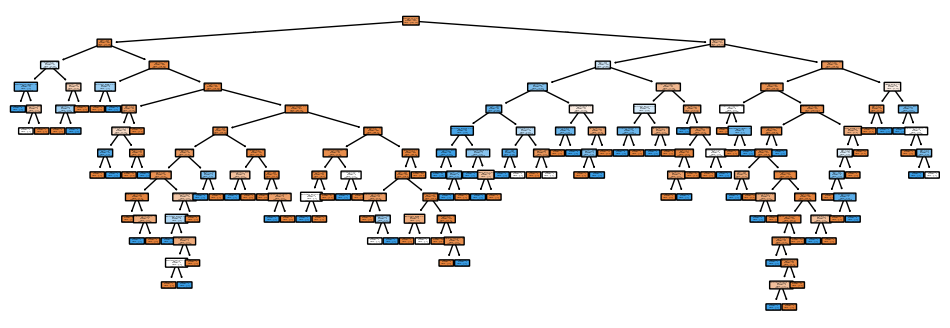

In [65]:
## NOTE: We can plot the tree and it is huge!
plt.figure(figsize=(12, 4))
plot_tree(clf_dt,
          filled=True,
          rounded=True,
          class_names=["No Attrition", "Yes Attrition"],
          feature_names=X_encoded.columns);

##### Confusion Matrix

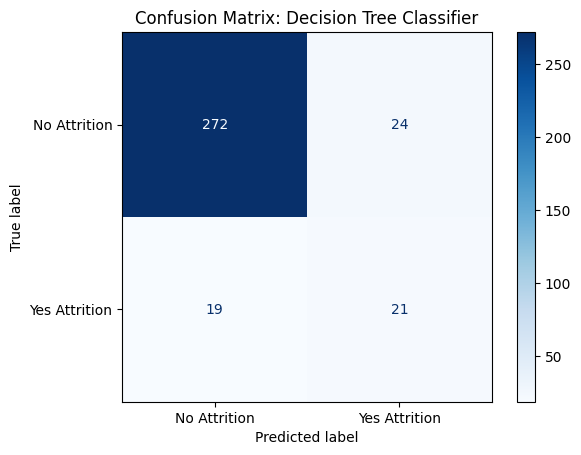

In [66]:
from sklearn.metrics import ConfusionMatrixDisplay

# Generate and display the confusion matrix using the test data
ConfusionMatrixDisplay.from_estimator(
    estimator=clf_dt,             # The trained decision tree classifier
    X=X_test,                     # Test features
    y=y_test,                     # Test labels
    display_labels=["No Attrition", "Yes Attrition"],  # Custom labels
    cmap=plt.cm.Blues,            # Blue gradient for better readability
    colorbar=True                 # Adds a colorbar for interpretation
)

plt.title("Confusion Matrix: Decision Tree Classifier")
plt.show()

#### Hyper-parameter Tuning

##### Alpha method

In [23]:
path = clf_dt.cost_complexity_pruning_path(X_train, y_train) # determine values for alpha
ccp_alphas = path.ccp_alphas # extract different values for alpha
ccp_alphas = ccp_alphas[:-1] # exclude the maximum value for alpha, which is just the clf as is

clf_dts = [] # create an array that we will put decision trees into

## now create one decision tree per value for alpha and store it in the array
for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=373, ccp_alpha=ccp_alpha)
    clf_dt.fit(X_train, y_train)
    clf_dts.append(clf_dt)

In [ ]:
train_scores = [clf_dt.score(X_train, y_train) for clf_dt in clf_dts]
test_scores = [clf_dt.score(X_test, y_test) for clf_dt in clf_dts]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")

# Set y-axis limits to range [0, 1.1]
ax.set_ylim(0.5, 1.1)

# Plot training and testing accuracy
ax.plot(ccp_alphas, train_scores, marker='o', label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [ ]:
clf_dt = DecisionTreeClassifier(random_state=373, ccp_alpha=0.045) # create the tree with ccp_alpha=0.016

## now use 5-fold cross validation create 5 different training and testing datasets that
## are then used to train and test the tree.
## NOTE: We use 5-fold because we don't have tons of data...
scores = cross_val_score(clf_dt, X_train, y_train, cv=5)
df = pd.DataFrame(data={'tree': range(5), 'accuracy': scores})

df.plot(x='tree', y='accuracy', marker='o', linestyle='--')

In [ ]:
## create an array to store the results of each fold during cross validiation
alpha_loop_values = []

## For each candidate value for alpha, we will run 5-fold cross validation.
## Then we will store the mean and standard deviation of the scores (the accuracy) for each call
## to cross_val_score in alpha_loop_values...
for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    scores = cross_val_score(clf_dt, X_train, y_train, cv=5)
    alpha_loop_values.append([ccp_alpha, np.mean(scores), np.std(scores)])

## Now we can draw a graph of the means and standard deviations of the scores
## for each candidate value for alpha
alpha_results = pd.DataFrame(alpha_loop_values,
                             columns=['alpha', 'mean_accuracy', 'std'])

alpha_results.plot(x='alpha',
                   y='mean_accuracy',
                   yerr='std',
                   marker='o',
                   linestyle='--')

In [ ]:
alpha_results[(alpha_results['alpha'] > 0.004)
              &
              (alpha_results['alpha'] < 0.006)]

In [ ]:
ideal_ccp_alpha = alpha_results[(alpha_results['alpha'] > 0.004)
                                &
                                (alpha_results['alpha'] < 0.006)]['alpha']
ideal_ccp_alpha

In [ ]:
# Check if ideal_ccp_alpha is a pandas Series and extract its value if necessary
if isinstance(ideal_ccp_alpha, pd.Series):
    ideal_ccp_alpha = float(ideal_ccp_alpha.iloc[0])
else:
    ideal_ccp_alpha = float(ideal_ccp_alpha)

print('Ideal Alpha:', ideal_ccp_alpha)


##### Gridsearch method

In [67]:
# Initial Parameter grid tuning
param_grid = {
    'criterion': ['gini', 'entropy'],        # Use both splitting criteria
    'max_depth': [10, 20, 30],         # Allow deeper trees or unlimited depth
    'min_impurity_decrease': [0, 0.001],     # Allow very small impurity decreases
    'min_samples_split': [2, 5],             # Allow splits with smaller samples
    'min_samples_leaf': [1, 2]               # Allow smaller leaf nodes
}

cv_folds = 5

In [68]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# GridSearchCV
gridSearch = GridSearchCV(
    estimator=clf_dt,         # Model to optimize
    param_grid=param_grid,    # Parameter grid
    cv=cv_folds,                     # Number of cross-validation folds
    scoring='accuracy',       # Scoring metric (can be adjusted)
    verbose=1                 # Print progress during search
)

# Fit GridSearchCV to the training data
gridSearch.fit(X_encoded, y_encoded)

# Print best parameters and best score
print('Best score: ', gridSearch.best_score_)
print('Best parameters: ', gridSearch.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best score:  0.8908102345415779
Best parameters:  {'criterion': 'entropy', 'max_depth': 20, 'min_impurity_decrease': 0.001, 'min_samples_leaf': 2, 'min_samples_split': 5}


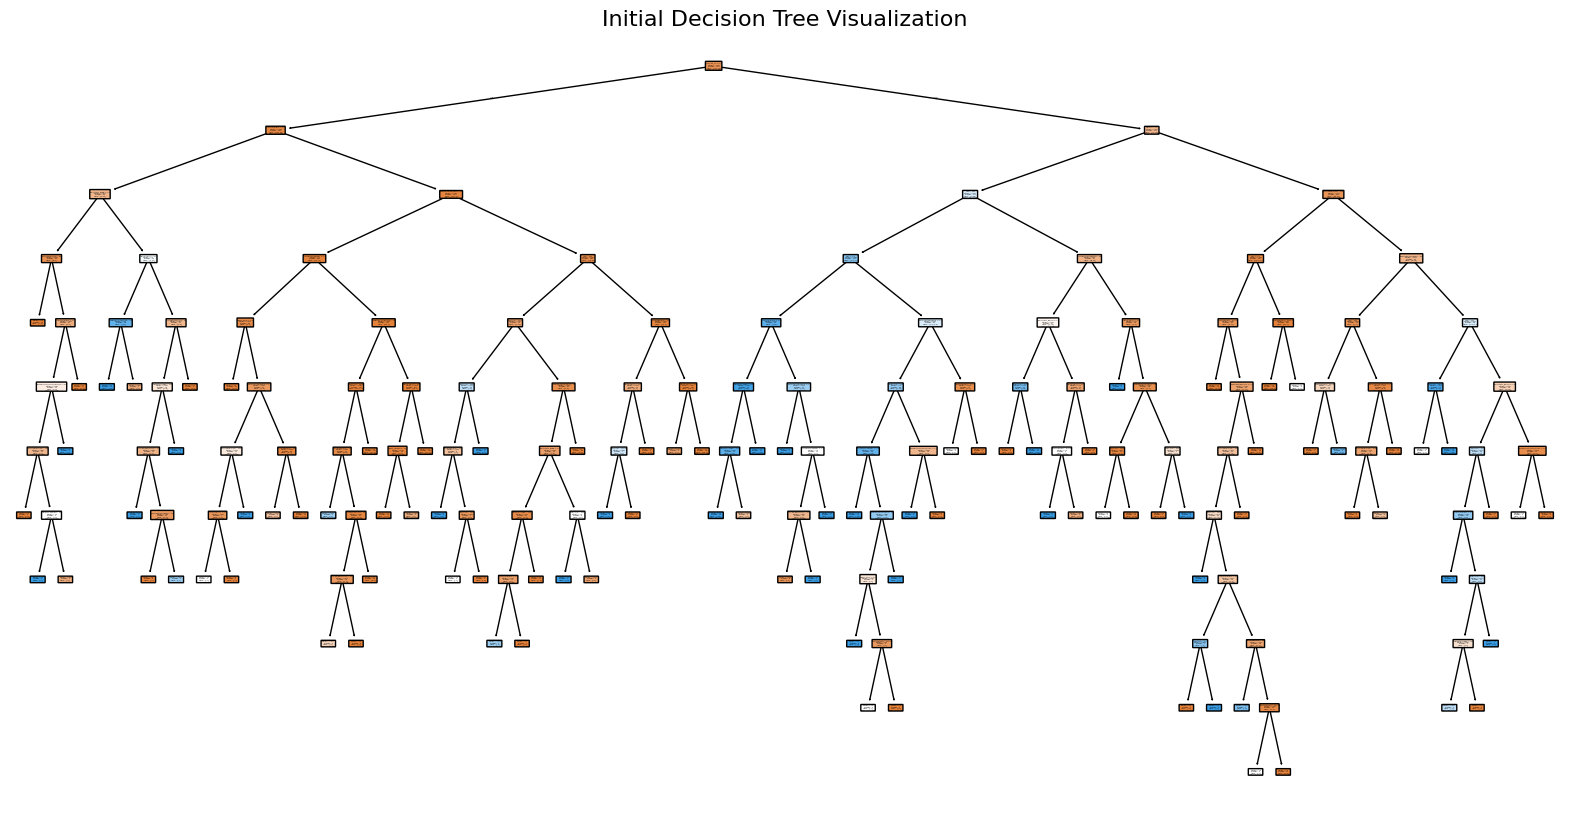

In [69]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Get the best decision tree model from GridSearchCV
best_clf = gridSearch.best_estimator_

# Plot the decision tree
plt.figure(figsize=(20, 10))  # Adjust the size for better visibility
plot_tree(
    best_clf,
    feature_names=X_encoded.columns,  # Replace with actual feature names
    class_names=["No Attrition", "Yes Attrition"],  # Replace with actual class names
    filled=True,                     # Color the nodes based on class distribution
    rounded=True                     # Rounded corners for better readability
)

plt.title("Initial Decision Tree Visualization", fontsize=16)
plt.show()

In [79]:
# Initial Parameter grid tuning
param_grid = {
    'criterion': ['gini', 'entropy'],        # Use both splitting criteria
    'max_depth': [4],         # Allow deeper trees or unlimited depth
    'min_impurity_decrease': [0.05, 0.0001],     # Allow very small impurity decreases
    'min_samples_split': [4]#,             # Allow splits with smaller samples
    #'min_samples_leaf': [1, 2]               # Allow smaller leaf nodes
}

cv_folds = 5

In [80]:
# Updated GridsearchCV (wash, rinse, repeat)
gridSearch = GridSearchCV(clf_dt,
                           param_grid,
                           cv=cv_folds)

# fit gridsearch to training data
gridSearch.fit(X_encoded, y_encoded)

# Print best parameters and best score
print('Best score: ', gridSearch.best_score_)
print('Best parameters: ', gridSearch.best_params_)

Best score:  0.895586353944563
Best parameters:  {'criterion': 'entropy', 'max_depth': 4, 'min_impurity_decrease': 0.0001, 'min_samples_split': 4}


In [81]:
# Evaluate the final model on validatoipn data
best_clf = gridSearch.best_estimator_
y_pred = best_clf.predict(X_test)
valid_accuracy = best_clf.score(X_test, y_test)

print("Accuracy on validation set:", valid_accuracy)

Accuracy on validation set: 0.9107142857142857


### Final Model

#### Final Decision Tree Plot

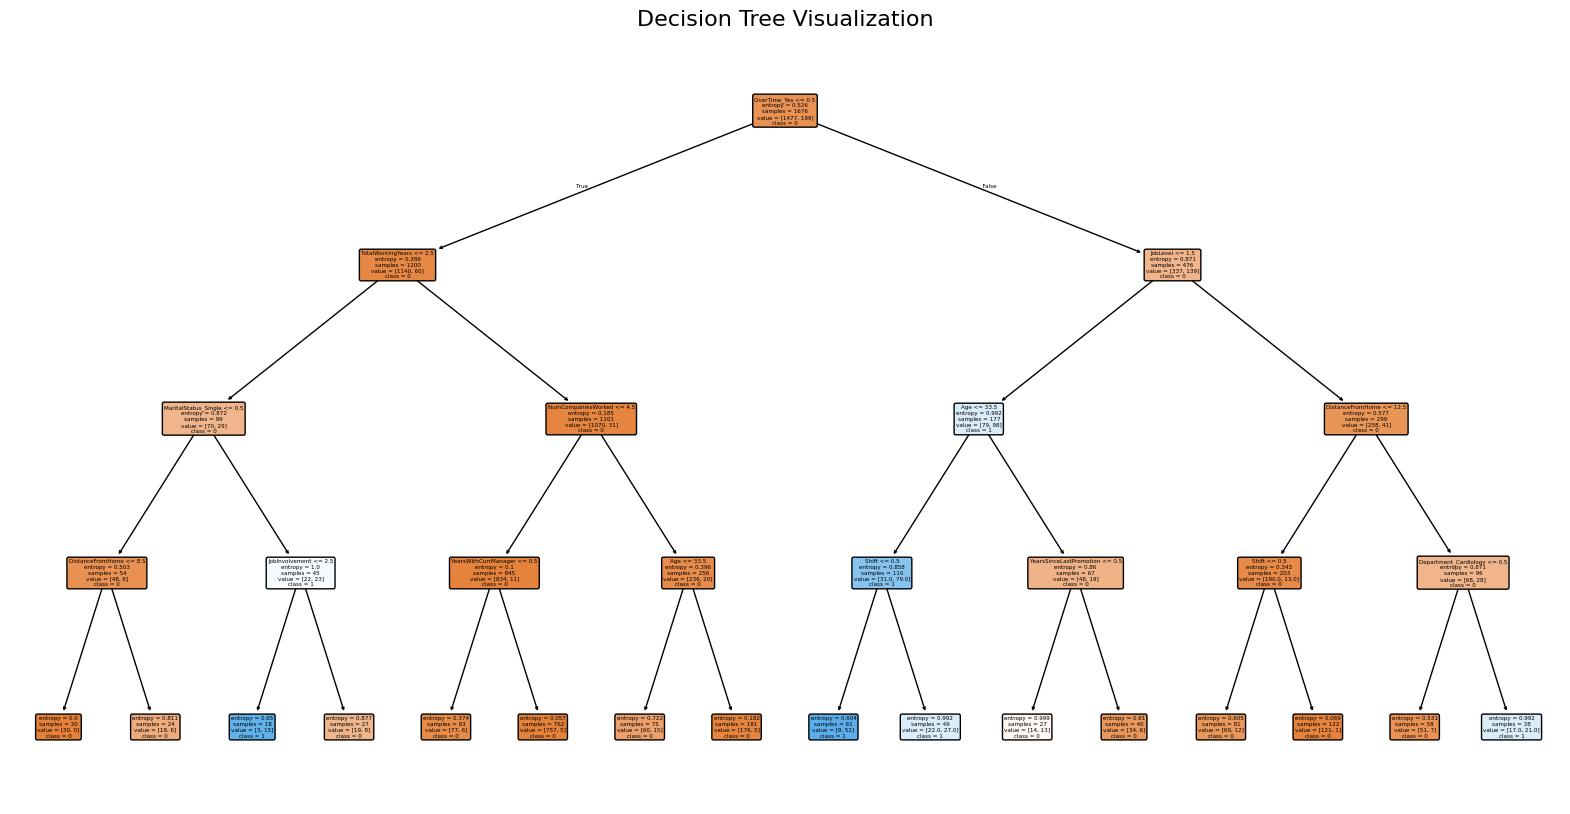

In [82]:
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(
    best_clf,
    feature_names=X_encoded.columns,  # Replace with your actual feature names
    class_names=best_clf.classes_.astype(str),  # Replace with your class names if available
    filled=True,  # Color the nodes
    rounded=True  # Rounded corners for readability
)
plt.title("Decision Tree Visualization", fontsize=16)
plt.show()

#### Final Confusion Matrix

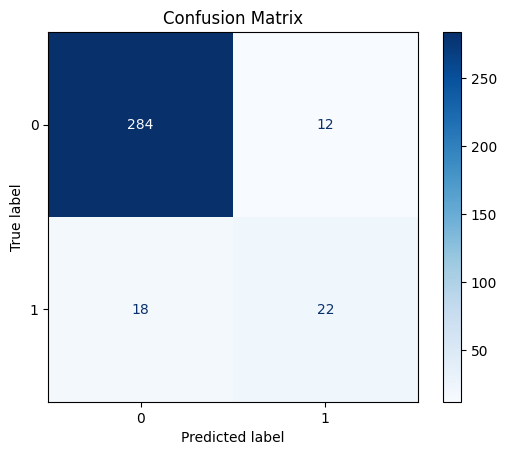

In [83]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_clf.classes_)

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Stage 6: Go!

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Overtime
Feature names seen at fit time, yet now missing:
- BusinessTravel_Non-Travel
- BusinessTravel_Travel_Frequently
- BusinessTravel_Travel_Rarely
- DailyRate
- Department_Cardiology
- ...
